# Run Galfit on HST galaxies
- 11/11/2020: Updated to use galfit_helpers.py module

### Load modules

In [1]:
from __future__ import division
import sys
sys.path.insert(0,'/data/emiln/XLSSC122_GalPops/Analysis/Modules')
from GalfitPyWrap import galfitwrap as gf
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import glob
from scipy import ndimage
from astropy import units as u
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.io import fits, ascii
from astropy.table import Table, hstack, join
import pickle
import fnmatch
import multiprocessing as mp
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import galfit_helpers as gfh

### Load HST galaxy catalog


In [3]:
HST_cat_root = '/data/emiln/XLSSC122_GalPops/Data/HST/Products/catalogs/'
HST_cat_filename = HST_cat_root+'xlssc122_F105_F140_redshifts_short_v4_snr_em_member2_by_hand.cat'
full_df, member_df = gfh.load_HST_galaxy_catalog(HST_cat_filename)
# z2_filtered_df = gfh.load_HST_galaxy_catalog(HST_cat_filename,  mag='F140W', magthresh=24, z=2.00, z_thresh=0.1, overwrite=False, verbose=True, goodfit=True) 

In [4]:
member_df.columns.values

array(['phot-id', 'ra', 'dec', 'f105_kron', 'f105_ekron', 'f105_0p8',
       'f105_e0p8', 'f140_kron', 'f140_ekron', 'f140_0p8', 'f140_e0p8',
       'asec_fwhm', 'zz', 'zlo', 'zhi', 'chi', 'spec-id', 'mcode', 'snr',
       'em-code', 'member1', 'member2', 'gold_cluster', 'gold_foreground',
       'silver_cluster', '(f140)kron', 'color', 'F140W', 'ID', 'RA',
       'DEC', 'r_center', 'X', 'Y'], dtype=object)

### Set Galfit parameters

In [29]:
# fit_df = filtered_df[0:4]
fit_df = member_df
df_name = 'XLSSC122_3DHSTPSF'
psf_root = '/data/emiln/XLSSC122_GalPops/Data/HST/Products/PSF/'
# psf_file = psf_root+'cosmos_3dhst.v4.0.F140W_psf.fits' # Filename causes galfit to seg fault
psf_file = psf_root+'3DHST_F140W_PSF.fits'
PSFf = 1 
convbox='128 128'
image_width = 400 # 200 for mag<23 objects, 400 for z2 objects
timeout=5*60
verbose=True
width=10
HLRwidth=5 # Cutout width = 2*HLRwidth
PA_INIT = 45
AR_INIT = 0.5
ZP = 26.465 # https://iopscience.iop.org/article/10.1088/0067-0049/214/2/24/pdf page 13, page 20 --> All cataloged fluxes are normalized to AB zero point = 25
# ZP = 25
MAG_INIT = 21
fitMagnitude = True
neighbourMagThresh=3
DYNMAG = True
sky='Default'
sky_INIT=0.00001
sigma_file = '/sigma_rms_cps.fits'
data_file = '/data_cps.fits'
constraint_file = 'galfit_constr.txt' # Matches van der wel 2012 constraints
# constr_file = 'none'
badmask='none'
save_name = None

In [30]:
params = {
    'survey':'HST',
    'fit_df':fit_df, # Dataframe with objects to be fit
    'full_df':full_df, # Unfiltered source catalog used for fitting neighbours
    'width':width, # Fitting region width in pixels
    'HLRwidth':HLRwidth, # Fitting region width in # of HLR
    'sigma_file':sigma_file, # Filename of sigma maps for sources
    'data_file':data_file, # Filename for data cutouts for each source
    'PSF_file':psf_file, # File_name of PSF to be used
    'usePSF':True, # Use PSF in fitting?
    'timeout':timeout, # Max runtime per object in seconds
    'PSFf':PSFf, # Fine sampling factor
    'verbose':verbose, # Verbose mode
    'PA_INIT':PA_INIT, # Initial position angle
    'AR_INIT':AR_INIT, # Initial axis ratio
    'MAG_INIT':MAG_INIT, # Initial magnitude
    'convbox':convbox, # Region to convolve PSF with in pixels (i.e. '100 100')
    'ZP':ZP, # Zeropoint 
    'constraint_file':constraint_file, # Galfit constraint filename
    'image_width':image_width, # Size of data+sigma images being used (200 for COSMOS cutouts)
    'useDYNMAG':DYNMAG, # Initialize magnitudes from catalog?
    'badmask':badmask, # filename for bad pixel mask
    'fitMagnitude':fitMagnitude, # Fit magnitudes?
    'sky':sky, # Sky fitting mode for galfit (i.e. 'default')
    'sky_INIT':sky_INIT, # Initial sky level
    'neighbourMagThresh':neighbourMagThresh, # Additional magnitude threshhold to fit neighbours (i.e. 3 -> only neighbours with mag < source_mag+3 are fit)
    'df_name': df_name, # Descriptive name of catalog being fit
    'save_name':save_name # Filename to save results to, overrides default
}

In [31]:
new_df, savename = gfh.run_galfit_parallel(params,**params) # Feeds in unwrapped params as well as a copy to be passed as kwargs to sub functions

': '-4.682e-03 +/- 1.862e-03', '2_XC': '[400.0000]', '2_DSDX': '[0.000e+00]', '2_DSDY': '[0.000e+00]', 'COMP_2': 'sky'}]
['5.3473']
['7.1281']
['21.9725']
['0.4280']
['0.7731']
['0.0286']
['-4.682e-03']
['1.862e-03']
ID 920 len(n_val)>1 True
***HST***
Initializing 232 with F140W Kron magnitude: 24.01
ID 232
RA: 34.440507000000004
DEC: -3.7703589999999996
Initial X: 1820.859741911856
Initial Y: 1502.7426987292317
Cutout X: 400
Cutout Y: 400
Cutout width: 400
Cutoutwidth (pixels) for ID 232 : 48
Cutoutwidth (arcsec) for ID 232 : 2.88
Bounds: [376, 424, 376, 424]
0 NEIGHBOURS FOUND
Adding additional model components for neighbours...
Using PSF
Running galfit from CWD: /data/emiln/XLSSC122_GalPops/Data/Products/HST/galfit_results/232
1_XC 400.5638 +/- 0.0522
1_YC 400.4600 +/- 0.0568
1_MAG 23.9130 +/- 0.4071
1_RE 2.1493 +/- 1.8094
1_N 8.3549 +/- 7.1541
1_AR 0.7310 +/- 0.0849
1_PA -0.1078 +/- 10.9047
2_XC *413.3662* +/- *1.3836*
2_YC 391.8113 +/- 0.5347
2_MAG 25.1744 +/- 0.4094
2_RE 2.9057 +

### Validate results

In [33]:
new_df

,ID,ra,dec,re,re_err,ar,ar_err,n,n_err,mag,mag_err,sky,sky_err,chi2nu,ErrorValue
0,529,34.434215,-3.758796,65.7991,21.5265,0.8797,0.0071,7.0077,0.6289,19.9677,0.1996,0.002517,0.001281,0.377765,0
1,455,34.422282,-3.763513,92.5058,80.1740,0.8402,0.0131,9.0613,1.8917,20.0301,0.4724,-0.022500,0.002400,1.037686,0
2,661,34.434096,-3.757658,4.7123,0.2116,0.8509,0.0098,3.1949,0.1514,22.0367,0.0289,0.005180,0.000437,0.307322,0
3,1036,34.432450,-3.749924,8.4980,1.1461,0.4820,0.0082,5.4668,0.4622,21.8994,0.0710,-0.004883,0.000735,0.383878,0
4,300,34.435031,-3.767948,2.3412,0.0616,0.7073,0.0137,3.0771,0.2074,22.4060,0.0196,0.000040,0.000435,0.442523,0
5,920,34.435628,-3.753143,5.3473,7.1281,0.7731,0.0286,20.0000,12.7589,21.9725,0.4280,-0.004682,0.001862,0.630946,16
6,305,34.447153,-3.768007,49.5238,36.8960,0.4244,0.0086,12.9276,2.6993,21.3759,0.2984,-0.004755,0.000874,0.294775,16
7,1057,34.436886,-3.750173,3.2880,0.0406,0.5446,0.0086,1.6751,0.0720,22.7559,0.0109,0.000082,0.000207,0.273834,0
8,1065,34.435917,-3.749538,4.5509,0.3144,0.3885,0.0402,0.9348,0.2084,22.7841,0.0424,0.017900,0.000900,16.484470,0
9,608,34.438450,-3.760699,2.4099,0.0337,0.7876,0.0119,1.2527,0.0680,22.8732,0.0080,-0.001589,0.000236,0.361915,0


In [38]:
new_df

,ID,ra,dec,re,ar,n,mag,sky,chi2nu,ErrorValue
0,529,34.434215,-3.758796,19.427300,0.8488,4.6792,20.6667,0.004387,0.790815,0
1,455,34.422282,-3.763513,5.809900,0.8177,2.8275,21.7138,-0.002986,0.509092,0
2,661,34.434096,-3.757658,5.128400,0.8190,3.4535,21.9950,0.004715,0.369403,0
3,1036,34.432450,-3.749924,5.037400,0.4860,3.6866,22.1944,-0.000664,0.307441,0
4,300,34.435031,-3.767948,2.406300,0.7044,3.2081,22.3882,-0.000627,0.320231,0
5,920,34.435628,-3.753143,1.885100,0.7558,10.3458,22.3709,-0.001342,0.350547,16
6,305,34.447153,-3.768007,19.765500,0.4129,9.8615,21.7751,-0.002506,0.276117,0
7,1057,34.436886,-3.750173,3.306400,0.5469,1.6844,22.7495,-0.000327,0.262762,0
8,1065,34.435917,-3.749538,6.321800,0.4291,1.6058,22.3973,0.001183,0.686399,0
9,608,34.438450,-3.760699,0.009298,0.8579,6.4706,22.9337,-0.001989,1.514832,4


    ID         ra       dec       re      ar       n      mag       sky  \
0  529  34.434215 -3.758796  65.7991  0.8797  7.0077  19.9677  0.002517   

     chi2nu  ErrorValue  
0  0.377765           0  


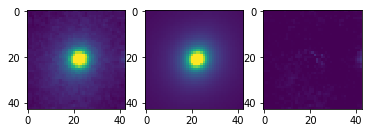

    ID         ra       dec       re      ar       n      mag     sky  \
1  455  34.422282 -3.763513  92.5058  0.8402  9.0613  20.0301 -0.0225   

     chi2nu  ErrorValue  
1  1.037686           0  


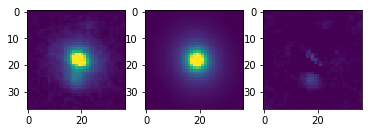

    ID         ra       dec      re      ar       n      mag      sky  \
2  661  34.434096 -3.757658  4.7123  0.8509  3.1949  22.0367  0.00518   

     chi2nu  ErrorValue  
2  0.307322           0  


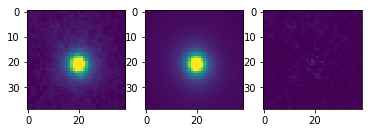

     ID        ra       dec     re     ar       n      mag       sky  \
3  1036  34.43245 -3.749924  8.498  0.482  5.4668  21.8994 -0.004883   

     chi2nu  ErrorValue  
3  0.383878           0  


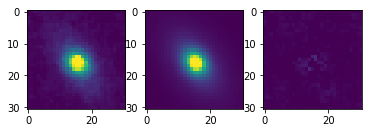

    ID         ra       dec      re      ar       n     mag      sky  \
4  300  34.435031 -3.767948  2.3412  0.7073  3.0771  22.406  0.00004   

     chi2nu  ErrorValue  
4  0.442523           0  


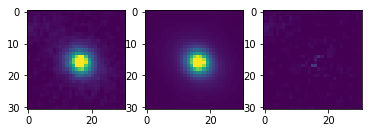

    ID         ra       dec      re      ar     n      mag       sky  \
5  920  34.435628 -3.753143  5.3473  0.7731  20.0  21.9725 -0.004682   

     chi2nu  ErrorValue  
5  0.630946          16  


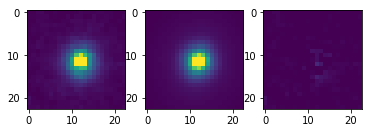

    ID         ra       dec       re      ar        n      mag       sky  \
6  305  34.447153 -3.768007  49.5238  0.4244  12.9276  21.3759 -0.004755   

     chi2nu  ErrorValue  
6  0.294775          16  


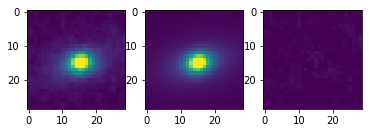

     ID         ra       dec     re      ar       n      mag       sky  \
7  1057  34.436886 -3.750173  3.288  0.5446  1.6751  22.7559  0.000082   

     chi2nu  ErrorValue  
7  0.273834           0  


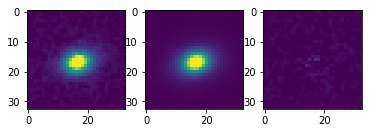

     ID         ra       dec      re      ar       n      mag     sky  \
8  1065  34.435917 -3.749538  4.5509  0.3885  0.9348  22.7841  0.0179   

     chi2nu  ErrorValue  
8  16.48447           0  


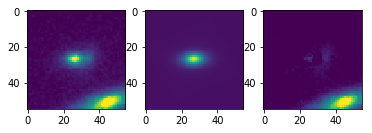

    ID        ra       dec      re      ar       n      mag       sky  \
9  608  34.43845 -3.760699  2.4099  0.7876  1.2527  22.8732 -0.001589   

     chi2nu  ErrorValue  
9  0.361915           0  


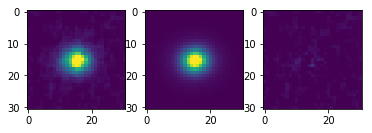

     ID         ra       dec      re      ar       n      mag       sky  \
10  243  34.422417 -3.770003  2.3935  0.6083  2.4806  22.4985 -0.001394   

      chi2nu  ErrorValue  
10  0.417507           0  


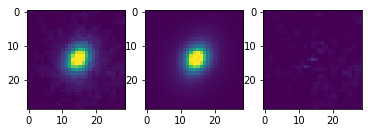

     ID         ra       dec       re      ar        n      mag     sky  \
11  644  34.433802 -3.758806  148.887  0.5486  15.2951  21.5391  0.0157   

      chi2nu  ErrorValue  
11  1.658071          16  


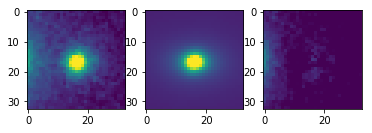

     ID         ra       dec      re      ar       n      mag       sky  \
12  847  34.434697 -3.754887  1.7969  0.8188  2.2465  23.3542  0.001785   

      chi2nu  ErrorValue  
12  0.275804           0  


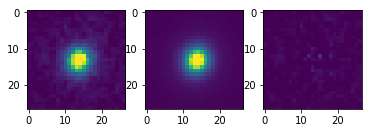

     ID         ra       dec       re      ar       n      mag       sky  \
13  375  34.444096 -3.765667  12.4408  0.7857  5.3547  22.3608 -0.002461   

      chi2nu  ErrorValue  
13  0.259584           0  


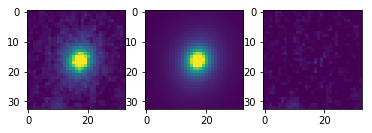

     ID         ra       dec      re      ar       n      mag       sky  \
14  735  34.425011 -3.758034  2.7471  0.4972  2.7517  23.1879 -0.002292   

      chi2nu  ErrorValue  
14  0.274544           0  


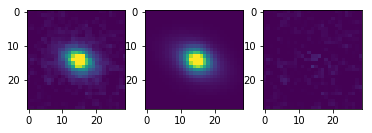

      ID         ra       dec      re      ar       n      mag       sky  \
15  1223  34.443347 -3.745001  1.4088  0.7807  2.4132  23.3464 -0.001047   

      chi2nu  ErrorValue  
15  0.296739           0  


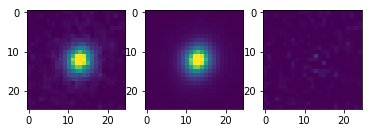

     ID         ra       dec      re      ar       n      mag       sky  \
16  347  34.441846 -3.766667  4.5584  0.6281  2.1023  23.3802 -0.000565   

      chi2nu  ErrorValue  
16  0.294684           0  


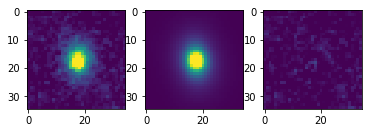

     ID         ra       dec      re      ar       n      mag       sky  \
17  146  34.444783 -3.772856  7.1312  0.4918  0.9158  22.8268 -0.001327   

      chi2nu  ErrorValue  
17  0.311517           0  


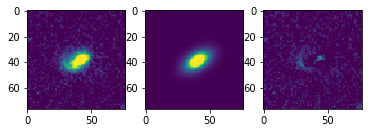

     ID         ra       dec      re      ar       n      mag       sky  \
18  497  34.433001 -3.763179  4.1181  0.9341  5.2409  23.0441 -0.004111   

      chi2nu  ErrorValue  
18  0.268964           0  


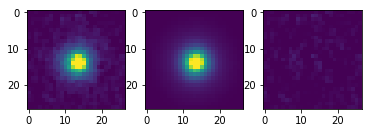

     ID         ra       dec      re      ar       n      mag       sky  \
19  604  34.439389 -3.760298  8.0706  0.2965  0.5566  23.2393 -0.001656   

      chi2nu  ErrorValue  
19  0.270883           0  


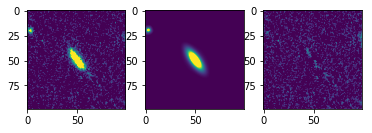

      ID         ra       dec      re      ar       n      mag       sky  \
20  1147  34.433624 -3.747747  1.6054  0.5659  1.2536  23.8132  0.002469   

      chi2nu  ErrorValue  
20  0.376773           0  


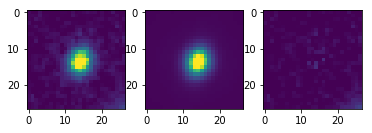

     ID         ra       dec      re      ar       n     mag       sky  \
21  407  34.446407 -3.765319  5.1195  0.4583  2.8822  23.215 -0.002877   

      chi2nu  ErrorValue  
21  0.466707           0  


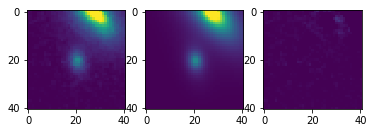

     ID         ra       dec      re      ar       n      mag       sky  \
22  731  34.439754 -3.758259  1.4965  0.5998  2.4063  23.7507 -0.002884   

      chi2nu  ErrorValue  
22  0.272054           0  


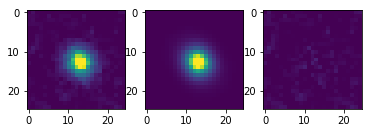

     ID         ra       dec       re      ar        n      mag     sky  \
23  653  34.433963 -3.759267  36.1491  0.6284  17.2905  22.7623  0.0148   

      chi2nu  ErrorValue  
23  0.751587          16  


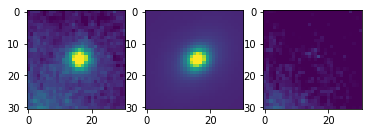

     ID         ra      dec      re     ar       n     mag       sky  \
24  469  34.418647 -3.76372  2.1493  0.731  8.3549  23.913  0.000577   

      chi2nu  ErrorValue  
24  0.437558           0  


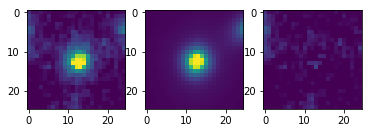

     ID         ra       dec      re      ar       n      mag       sky  \
25  726  34.430604 -3.757624  10.358  0.7116  0.9796  23.2551 -0.001155   

      chi2nu  ErrorValue  
25  0.276744           0  


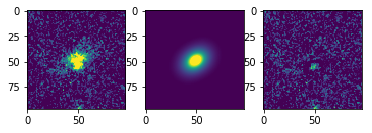

     ID         ra       dec      re      ar       n      mag       sky  \
26  232  34.440507 -3.770359  4.5819  0.5622  1.0435  23.8621 -0.001308   

      chi2nu  ErrorValue  
26  0.263772           0  


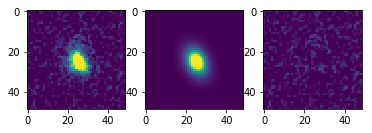

     ID         ra       dec      re      ar       n      mag       sky  \
27  454  34.418951 -3.763868  7.2464  0.5955  0.4342  23.6064 -0.001932   

      chi2nu  ErrorValue  
27  0.295821           0  


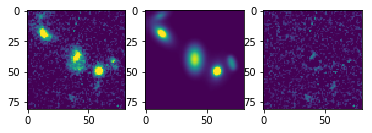

     ID         ra       dec      re      ar       n      mag       sky  \
28  808  34.447713 -3.756092  7.2141  0.3813  0.7703  23.7973  0.001288   

      chi2nu  ErrorValue  
28  0.251839           0  


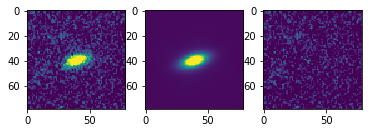

     ID        ra       dec      re      ar       n      mag       sky  \
29  240  34.45158 -3.770285  6.3013  0.4545  1.2329  22.8667 -0.000687   

      chi2nu  ErrorValue  
29  0.252484           0  


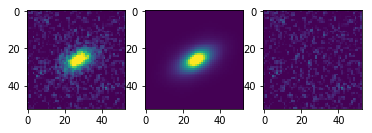

     ID         ra       dec      re      ar       n      mag       sky  \
30  554  34.435274 -3.762475  4.8947  0.2685  0.3538  23.8766 -0.000334   

      chi2nu  ErrorValue  
30  0.381845           0  


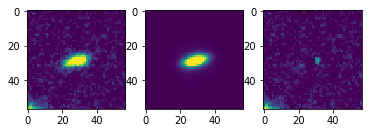

     ID         ra       dec      re      ar       n      mag       sky  \
31  334  34.427611 -3.767412  3.3299  0.3159  0.1865  24.2309 -0.001705   

      chi2nu  ErrorValue  
31  0.253918           0  


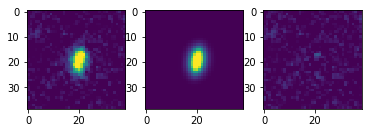

      ID         ra       dec      re      ar       n      mag       sky  \
32  1127  34.438735 -3.748219  3.1798  0.6326  2.1063  24.1857 -0.001301   

      chi2nu  ErrorValue  
32  0.262753           0  


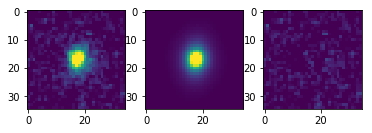

     ID         ra       dec      re      ar       n      mag       sky  \
33  525  34.418961 -3.762811  3.9278  0.3162  0.1165  24.5291  0.004043   

      chi2nu  ErrorValue  
33  1.652079           0  


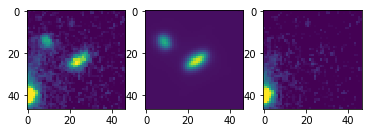

     ID         ra       dec       re      ar       n      mag      sky  \
34  434  34.446607 -3.764467  12.5571  0.3846  2.7146  23.4169 -0.00126   

      chi2nu  ErrorValue  
34  0.259176           0  


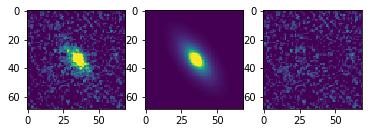

     ID         ra       dec      re      ar       n      mag       sky  \
35  266  34.421055 -3.769239  5.6048  0.2313  0.9426  24.0477 -0.002449   

      chi2nu  ErrorValue  
35  0.285577           0  


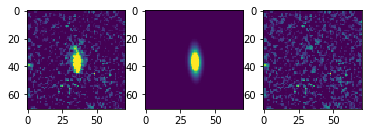

      ID         ra       dec      re      ar       n      mag       sky  \
36  1257  34.446333 -3.743596  7.5667  0.6284  0.8163  23.7428 -0.001104   

      chi2nu  ErrorValue  
36  0.309164           0  


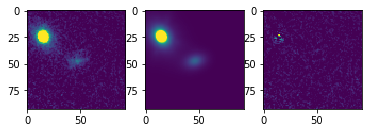

In [28]:
# Plot fits by ID
for ID in fit_df['ID']:
    gfh.plot_by_ID(ID,save_name=savename,survey='HST')

    ID         ra       dec       re   re_err      ar  ar_err       n   n_err  \
0  529  34.434215 -3.758796  65.7991  21.5265  0.8797  0.0071  7.0077  0.6289   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
0  19.9677   0.1996  0.002517  0.001281  0.377765           0  


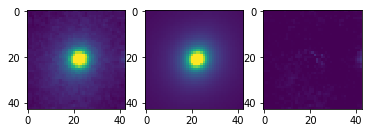

    ID         ra       dec       re  re_err      ar  ar_err       n   n_err  \
1  455  34.422282 -3.763513  92.5058  80.174  0.8402  0.0131  9.0613  1.8917   

       mag  mag_err     sky  sky_err    chi2nu  ErrorValue  
1  20.0301   0.4724 -0.0225   0.0024  1.037686           0  


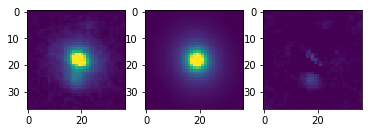

    ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
2  661  34.434096 -3.757658  4.7123  0.2116  0.8509  0.0098  3.1949  0.1514   

       mag  mag_err      sky   sky_err    chi2nu  ErrorValue  
2  22.0367   0.0289  0.00518  0.000437  0.307322           0  


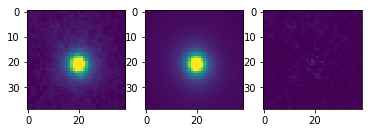

     ID        ra       dec     re  re_err     ar  ar_err       n   n_err  \
3  1036  34.43245 -3.749924  8.498  1.1461  0.482  0.0082  5.4668  0.4622   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
3  21.8994    0.071 -0.004883  0.000735  0.383878           0  


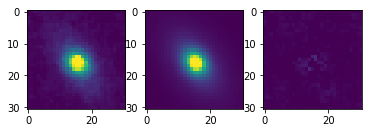

    ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
4  300  34.435031 -3.767948  2.3412  0.0616  0.7073  0.0137  3.0771  0.2074   

      mag  mag_err      sky   sky_err    chi2nu  ErrorValue  
4  22.406   0.0196  0.00004  0.000435  0.442523           0  


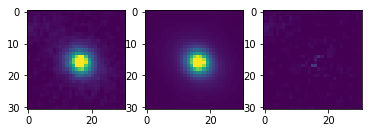

    ID         ra       dec      re  re_err      ar  ar_err     n    n_err  \
5  920  34.435628 -3.753143  5.3473  7.1281  0.7731  0.0286  20.0  12.7589   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
5  21.9725    0.428 -0.004682  0.001862  0.630946          16  


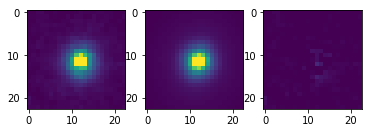

    ID         ra       dec       re  re_err      ar  ar_err        n   n_err  \
6  305  34.447153 -3.768007  49.5238  36.896  0.4244  0.0086  12.9276  2.6993   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
6  21.3759   0.2984 -0.004755  0.000874  0.294775          16  


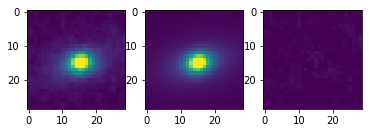

     ID         ra       dec     re  re_err      ar  ar_err       n  n_err  \
7  1057  34.436886 -3.750173  3.288  0.0406  0.5446  0.0086  1.6751  0.072   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
7  22.7559   0.0109  0.000082  0.000207  0.273834           0  


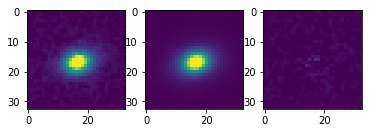

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
8  1065  34.435917 -3.749538  4.5509  0.3144  0.3885  0.0402  0.9348  0.2084   

       mag  mag_err     sky  sky_err    chi2nu  ErrorValue  
8  22.7841   0.0424  0.0179   0.0009  16.48447           0  


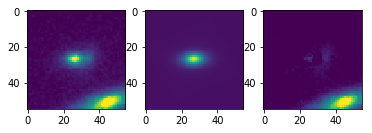

    ID        ra       dec      re  re_err      ar  ar_err       n  n_err  \
9  608  34.43845 -3.760699  2.4099  0.0337  0.7876  0.0119  1.2527  0.068   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
9  22.8732    0.008 -0.001589  0.000236  0.361915           0  


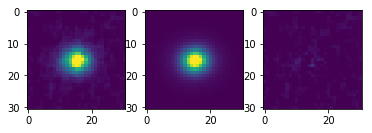

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
10  243  34.422417 -3.770003  2.3935   0.046  0.6083  0.0129  2.4806  0.1694   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
10  22.4985    0.017 -0.001394  0.000447  0.417507           0  


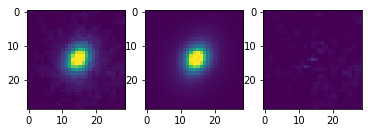

     ID         ra       dec       re    re_err      ar  ar_err        n  \
11  644  34.433802 -3.758806  148.887  756.2783  0.5486  0.0429  15.2951   

      n_err      mag  mag_err     sky  sky_err    chi2nu  ErrorValue  
11  16.2957  21.5391   2.0577  0.0157   0.0022  1.658071          16  


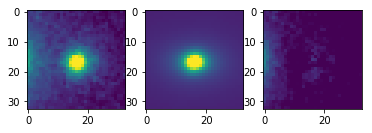

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
12  847  34.434697 -3.754887  1.7969   0.049  0.8188  0.0217  2.2465  0.2289   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
12  23.3542   0.0208  0.001785  0.000322  0.275804           0  


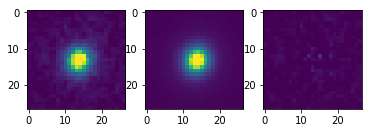

     ID         ra       dec       re  re_err      ar  ar_err       n   n_err  \
13  375  34.444096 -3.765667  12.4408  4.3688  0.7857  0.0174  5.3547  0.8946   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
13  22.3608   0.2032 -0.002461  0.000902  0.259584           0  


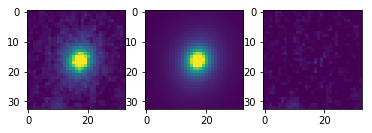

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
14  735  34.425011 -3.758034  2.7471  0.0881  0.4972  0.0151  2.7517  0.2326   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
14  23.1879   0.0243 -0.002292  0.000301  0.274544           0  


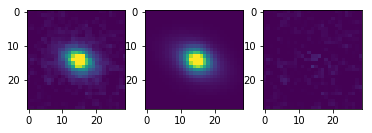

      ID         ra       dec      re  re_err      ar  ar_err       n  n_err  \
15  1223  34.443347 -3.745001  1.4088  0.0432  0.7807  0.0233  2.4132  0.282   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
15  23.3464   0.0185 -0.001047  0.000337  0.296739           0  


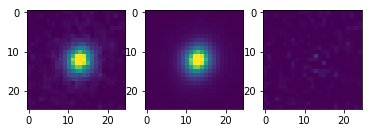

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
16  347  34.441846 -3.766667  4.5584  0.2802  0.6281  0.0184  2.1023  0.1935   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
16  23.3802   0.0463 -0.000565  0.000348  0.294684           0  


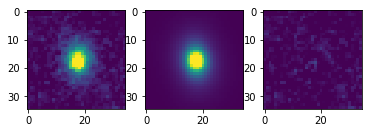

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
17  146  34.444783 -3.772856  7.1312  0.0926  0.4918  0.0056  0.9158  0.0272   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
17  22.8268   0.0085 -0.001327  0.000087  0.311517           0  


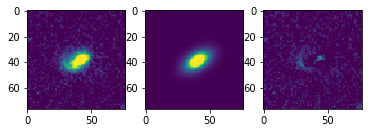

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
18  497  34.433001 -3.763179  4.1181   1.102  0.9341  0.0283  5.2409  1.0685   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
18  23.0441    0.142 -0.004111  0.000874  0.268964           0  


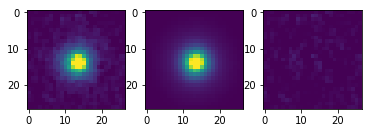

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
19  604  34.439389 -3.760298  8.0706  0.0897  0.2965  0.0043  0.5566  0.0258   

        mag  mag_err       sky  sky_err    chi2nu  ErrorValue  
19  23.2393   0.0087 -0.001656  0.00006  0.270883           0  


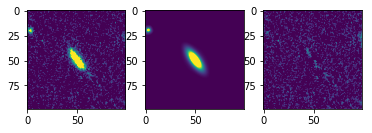

      ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
20  1147  34.433624 -3.747747  1.6054  0.0513  0.5659  0.0282  1.2536  0.2021   

        mag  mag_err       sky  sky_err    chi2nu  ErrorValue  
20  23.8132   0.0101  0.002469  0.00028  0.376773           0  


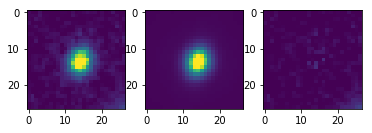

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
21  407  34.446407 -3.765319  5.1195  0.4698  0.4583  0.0185  2.8822  0.3346   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
21  23.215   0.0592 -0.002877  0.000305  0.466707           0  


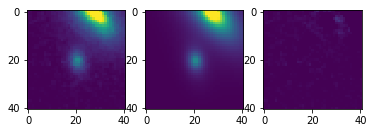

     ID         ra       dec      re  re_err      ar  ar_err       n  n_err  \
22  731  34.439754 -3.758259  1.4965  0.0559  0.5998  0.0315  2.4063  0.349   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
22  23.7507   0.0212 -0.002884  0.000271  0.272054           0  


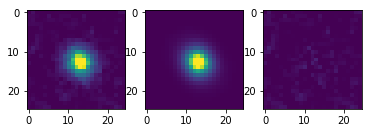

     ID         ra       dec       re    re_err      ar  ar_err        n  \
23  653  34.433963 -3.759267  36.1491  169.4337  0.6284  0.0615  17.2905   

      n_err      mag  mag_err     sky  sky_err    chi2nu  ErrorValue  
23  22.0779  22.7623   1.5863  0.0148   0.0013  0.751587          16  


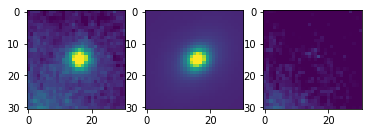

     ID         ra      dec      re  re_err     ar  ar_err       n   n_err  \
24  469  34.418647 -3.76372  2.1493  1.8094  0.731  0.0849  8.3549  7.1541   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
24  23.913   0.4071  0.000577  0.001109  0.437558           0  


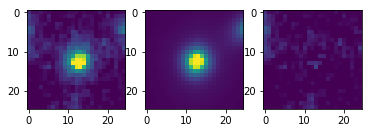

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
25  726  34.430604 -3.757624  10.358  0.3002  0.7116  0.0133  0.9796  0.0398   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
25  23.2551   0.0224 -0.001155  0.000062  0.276744           0  


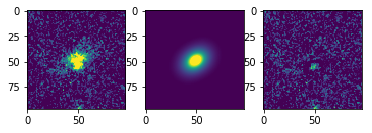

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
26  232  34.440507 -3.770359  4.5819  0.1207  0.5622  0.0161  1.0435  0.0609   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
26  23.8621   0.0188 -0.001308  0.000124  0.263772           0  


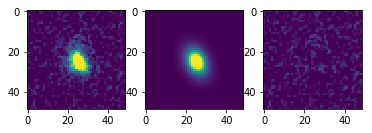

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
27  454  34.418951 -3.763868  7.2464  0.1278  0.5955  0.0102  0.4342  0.0308   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
27  23.6064   0.0132 -0.001932  0.000084  0.295821           0  


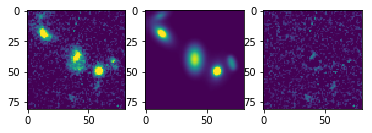

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
28  808  34.447713 -3.756092  7.2141   0.159  0.3813   0.008  0.7703  0.0482   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
28  23.7973   0.0141  0.001288  0.000076  0.251839           0  


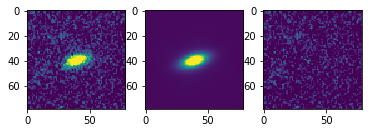

     ID        ra       dec      re  re_err      ar  ar_err       n   n_err  \
29  240  34.45158 -3.770285  6.3013  0.1851  0.4545  0.0109  1.2329  0.0614   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
29  22.8667    0.022 -0.000687  0.000225  0.252484           0  


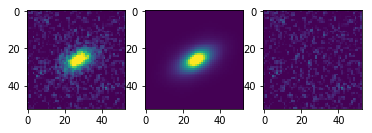

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
30  554  34.435274 -3.762475  4.8947  0.0805  0.2685  0.0112  0.3538  0.0459   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
30  23.8766   0.0122 -0.000334  0.000126  0.381845           0  


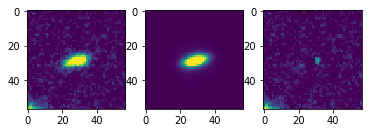

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
31  334  34.427611 -3.767412  3.3299  0.0647  0.3159  0.0179  0.1865  0.0617   

        mag  mag_err       sky  sky_err    chi2nu  ErrorValue  
31  24.2309   0.0098 -0.001705  0.00015  0.253918           0  


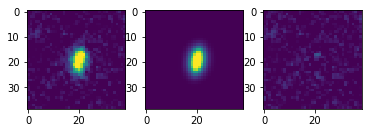

      ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
32  1127  34.438735 -3.748219  3.1798  0.2077  0.6326  0.0332  2.1063  0.3311   

        mag  mag_err       sky  sky_err    chi2nu  ErrorValue  
32  24.1857   0.0506 -0.001301  0.00022  0.262753           0  


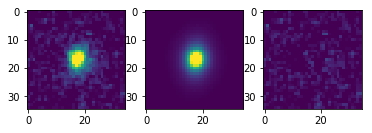

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
33  525  34.418961 -3.762811  3.9278  0.2571  0.3162  0.0508  0.1165  0.1847   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
33  24.5291   0.0333  0.004043  0.000344  1.652079           0  


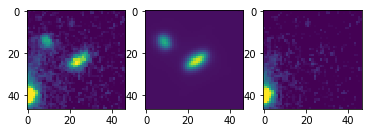

     ID         ra       dec       re  re_err      ar  ar_err       n   n_err  \
34  434  34.446607 -3.764467  12.5571  1.4235  0.3846  0.0142  2.7146  0.2688   

        mag  mag_err      sky   sky_err    chi2nu  ErrorValue  
34  23.4169   0.0766 -0.00126  0.000121  0.259176           0  


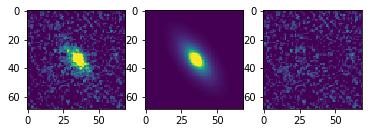

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
35  266  34.421055 -3.769239  5.6048  0.1563  0.2313  0.0125  0.9426  0.0838   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
35  24.0477   0.0166 -0.002449  0.000101  0.285577           0  


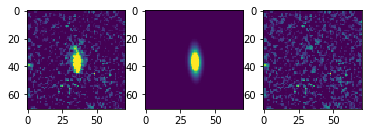

      ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
36  1257  34.446333 -3.743596  7.5667  0.2764  0.6284  0.0208  0.8163  0.0706   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
36  23.7428   0.0247 -0.001104  0.000104  0.309164           0  


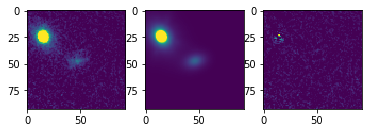

In [34]:
# Plot fits by ID
for ID in fit_df['ID']:
    gfh.plot_by_ID(ID,save_name=savename,survey='HST')